# Disaster / Not Disaster Tweet Classification

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Visualization

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [4]:
train_df.keyword.isna().sum()

61

In [5]:
train_df = train_df.sample(frac=1)
train_df.head()

,id,keyword,location,text,target
7541,10782,wreckage,"New Delhi,India",Wreckage 'Conclusively Confirmed' as From MH37...,1
5254,7514,oil%20spill,NaN,SYD traffic HAZARD Oil spill - BANKSTOWN Stace...,1
1506,2174,catastrophic,Inexpressible Island,The Catastrophic Effects of Hiroshima and Naga...,1
3941,5603,flood,New York,Spot Flood Combo 53inch 300W Curved Cree LED W...,0
1831,2632,crashed,London,This guy bought my car on Tuesday police knock...,1


In [6]:
import random
random_index = random.randint(0, len(train_df)-5)

for item in train_df[['text', 'target']].iloc[random_index:random_index+5].itertuples():
    _, text, target = item
    print('---')
    print(('Disaster') if target>0 else ('Not A Disaster'))
    print(text)

---
Disaster
Another fake hate crime Lesbians burn their own house down. What else Is new :http://t.co/66oBQmxImb
---
Disaster
#Flood in Bago Myanmar #We arrived Bago
---
Not A Disaster
Various issues fail to derail homes bid http://t.co/zhsLl7swBh
---
Not A Disaster
8 hours of bagging groceries = an aching body
---
Disaster
Police kill hatchet-wielding gunman who opened fire inside Nashville movie theater: AåÊmiddle-aged manåÊarmed wi... http://t.co/tyD47NfL5x


### Data Split into Train and Validation sets

In [7]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df.text, train_df.target, test_size=0.1)

In [8]:
train_sentences[:5]

6497    Damn there's really no MLK center that hasn't ...
5233    Alhaji Putin is far from being a good person s...
5837    #360WiseNews : China's Stock Market Crash: Are...
1268                                  Burned my popcorn??
3813    Loved the way this book was written to include...
Name: text, dtype: object

### Converting tweet text into numbers

In [9]:
sum([len(i.split()) for i in train_sentences]) / len(train_sentences)

14.894467960881624

In [10]:
from tensorflow.keras.layers import TextVectorization

max_vector_length = 15
max_vocab_words = 10000
text_vectorizer = TextVectorization(max_tokens=max_vocab_words, output_sequence_length=max_vector_length)

In [11]:
text_vectorizer.adapt(train_sentences)

In [12]:
random_sample = random.choice(train_sentences)
print(f'Original Text:\n {random_sample}\n')
print(f'Vectorized Text:')
text_vectorizer(random_sample)

Original Text:
 The U.S. also flew over each bomb site in World War II with warning letters telling people to evacuate

Vectorized Text:


<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([   2,   69,  303, 2459,   55, 1403,  107,  637,    5,  104,  142,
       1855,   14,  278, 2911], dtype=int64)>

### Getting Embeddings for the text

In [13]:
from tensorflow.keras.layers import Embedding

embedding = Embedding(input_dim=max_vocab_words, output_dim=128, input_length=max_vector_length)

In [15]:
random_sample = random.choice(train_sentences)
print(f'Original Text:\n{random_sample}\n')
print(f'Embeddings for the text:')
embedding(text_vectorizer([random_sample]))

Original Text:
@justinbieber @ArianaGrande Can you hear me screaming !!!!!

Embeddings for the text:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03764162, -0.03759648, -0.04481114, ..., -0.01500798,
         -0.04822445,  0.00212939],
        [-0.02847958, -0.02048204,  0.02991552, ...,  0.03334169,
          0.00530211,  0.04620883],
        [ 0.03669402, -0.0244064 ,  0.00125688, ..., -0.04634457,
         -0.02461439, -0.01942431],
        ...,
        [-0.0077719 ,  0.04532119, -0.01497868, ..., -0.04173332,
         -0.02455013, -0.03426999],
        [-0.0077719 ,  0.04532119, -0.01497868, ..., -0.04173332,
         -0.02455013, -0.03426999],
        [-0.0077719 ,  0.04532119, -0.01497868, ..., -0.04173332,
         -0.02455013, -0.03426999]]], dtype=float32)>

### Base Model using Naive Bayes from scikit learn

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

In [99]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

model.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [101]:
predictions = model.predict(val_sentences)

#### Model Evaluation

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def calculate_results(y_true, y_pred):
    print(f"Accuracy: {(y_true == y_pred).sum() / len(y_true)}")
    print(classification_report(y_true, y_pred))

    plt.figure(figsize=(8, 6))
    s = sns.heatmap(data=confusion_matrix(y_true, y_pred),
                    annot=True, fmt='g',
                    linewidths=5,)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.xlabel('Predictions', fontsize=20)
    plt.ylabel('True', fontsize=20)

Accuracy: 0.8149606299212598
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       449
           1       0.86      0.65      0.74       313

    accuracy                           0.81       762
   macro avg       0.83      0.79      0.80       762
weighted avg       0.82      0.81      0.81       762



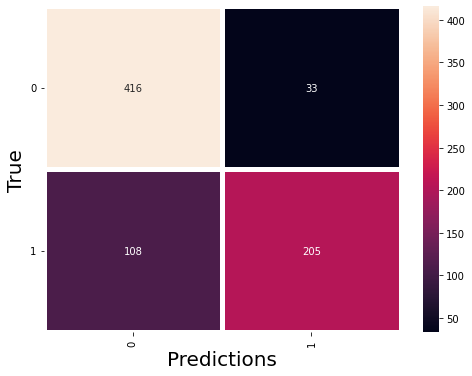

In [124]:
calculate_results(val_labels, predictions)

### Feed-forward Dense Model

In [18]:
import tensorflow as tf

In [197]:
inputs = tf.keras.layers.Input(shape=(1,), dtype='string')

x = text_vectorizer(inputs)
x = tf.keras.layers.Embedding(input_dim=max_vocab_words, output_dim=128, input_length=max_vector_length)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [198]:
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_9 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_4   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tr

In [199]:
history = model.fit(train_sentences,
                    train_labels, 
                    epochs=5, 
                    batch_size=32,
                    validation_data=(val_sentences, val_labels),
                    validation_batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                                patience=3,
                                                                restore_best_weights=True)])

Epoch 1/5
215/215 [==============================] - 5s 18ms/step - loss: 0.6128 - accuracy: 0.6927 - val_loss: 0.5236 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4427 - accuracy: 0.8143 - val_loss: 0.4618 - val_accuracy: 0.7900
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3481 - accuracy: 0.8613 - val_loss: 0.4509 - val_accuracy: 0.7940
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2851 - accuracy: 0.8897 - val_loss: 0.4576 - val_accuracy: 0.7953
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2382 - accuracy: 0.9129 - val_loss: 0.4709 - val_accuracy: 0.7927


In [200]:
predictions = tf.round(tf.squeeze(model.predict(val_sentences)))

24/24 [==============================] - 0s 2ms/step


Accuracy: 0.7926509186351706
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       449
           1       0.78      0.69      0.73       313

    accuracy                           0.79       762
   macro avg       0.79      0.78      0.78       762
weighted avg       0.79      0.79      0.79       762



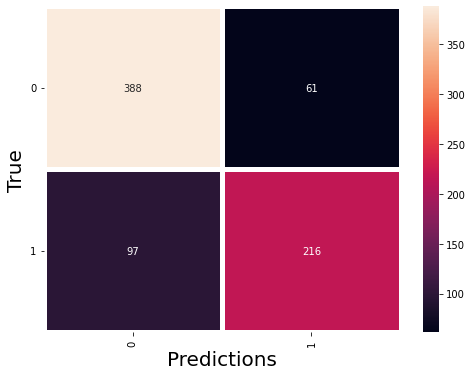

In [201]:
calculate_results(val_labels, predictions)

### RNN Model using LSTM Layers

In [183]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)
x = tf.keras.layers.Embedding(input_dim=max_vocab_words, output_dim=128, input_length=max_vector_length)(x)
# x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.LSTM(64)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [184]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm_10 (LSTM)              (None, 64)                49408     
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
________________________________________________

In [185]:
history = model.fit(train_sentences,
                    train_labels,
                    epochs=5,
                    batch_size=32,
                    validation_data=(val_sentences, val_labels),
                    validation_batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                                restore_best_weights=True,
                                                                patience=3)])

Epoch 1/5
215/215 [==============================] - 8s 26ms/step - loss: 0.5092 - accuracy: 0.7468 - val_loss: 0.4523 - val_accuracy: 0.7940
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.3114 - accuracy: 0.8720 - val_loss: 0.4827 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.2122 - accuracy: 0.9215 - val_loss: 0.5835 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.1482 - accuracy: 0.9466 - val_loss: 0.7405 - val_accuracy: 0.7493


In [186]:
predictions = tf.round(tf.squeeze(model.predict(val_sentences)))

24/24 [==============================] - 1s 4ms/step


Accuracy: 0.7939632545931758
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       449
           1       0.77      0.71      0.74       313

    accuracy                           0.79       762
   macro avg       0.79      0.78      0.78       762
weighted avg       0.79      0.79      0.79       762



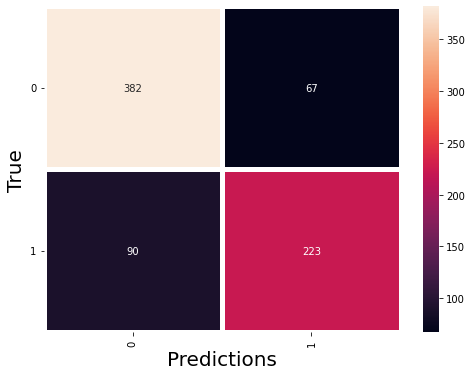

In [187]:
calculate_results(val_labels, predictions)

### RNN Model using GRU Layers

In [202]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)
x = tf.keras.layers.Embedding(input_dim=max_vocab_words, output_dim=128, input_length=max_vector_length)(x)
x = tf.keras.layers.GRU(64)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [203]:
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_10 (Embedding)    (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
________________________________________________

In [204]:
history = model.fit(train_sentences,
                    train_labels,
                    epochs=5,
                    batch_size=32,
                    validation_data=(val_sentences, val_labels),
                    validation_batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                                patience=3,
                                                                restore_best_weights=True)])

Epoch 1/5
215/215 [==============================] - 7s 25ms/step - loss: 0.5250 - accuracy: 0.7320 - val_loss: 0.4412 - val_accuracy: 0.8045
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.3175 - accuracy: 0.8689 - val_loss: 0.4637 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.2139 - accuracy: 0.9228 - val_loss: 0.5681 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.1531 - accuracy: 0.9456 - val_loss: 0.6369 - val_accuracy: 0.7822


In [205]:
predictions = tf.round(tf.squeeze(model.predict(val_sentences)))

24/24 [==============================] - 0s 4ms/step


### Bi-directional RNN Model

In [207]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)
x = tf.keras.layers.Embedding(max_vocab_words, 128, input_length=max_vector_length)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [208]:
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_11 (Embedding)    (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-tr

In [209]:
history = model.fit(train_sentences,
                    train_labels,
                    epochs=5,
                    batch_size=32,
                    validation_data=(val_sentences, val_labels),
                    validation_batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                                patience=3,
                                                                restore_best_weights=True)])

Epoch 1/5
215/215 [==============================] - 13s 40ms/step - loss: 0.5110 - accuracy: 0.7454 - val_loss: 0.4369 - val_accuracy: 0.8084
Epoch 2/5
215/215 [==============================] - 7s 33ms/step - loss: 0.3140 - accuracy: 0.8713 - val_loss: 0.4566 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 7s 35ms/step - loss: 0.2078 - accuracy: 0.9229 - val_loss: 0.6620 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 7s 34ms/step - loss: 0.1411 - accuracy: 0.9491 - val_loss: 0.6520 - val_accuracy: 0.7795


In [210]:
predictions = tf.round(tf.squeeze(model.predict(val_sentences)))

24/24 [==============================] - 1s 8ms/step


Accuracy: 0.8083989501312336
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       449
           1       0.85      0.65      0.74       313

    accuracy                           0.81       762
   macro avg       0.82      0.78      0.79       762
weighted avg       0.81      0.81      0.80       762



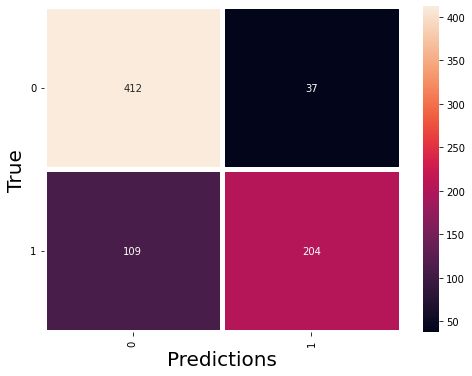

In [211]:
calculate_results(val_labels, predictions)

### 1D CNN Model

In [254]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)
x = tf.keras.layers.Embedding(max_vocab_words, 128, input_length=max_vector_length)(x)
x = tf.keras.layers.Conv1D(32, 5, activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [255]:
model.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_25 (Embedding)    (None, 15, 128)           1280000   
                                                                 
 conv1d_13 (Conv1D)          (None, 11, 32)            20512     
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_32 (Dense)            (None, 1)                 33 

In [256]:
history = model.fit(train_sentences,
                    train_labels,
                    epochs=5,
                    batch_size=32,
                    validation_data=(val_sentences, val_labels),
                    validation_batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                                patience=3,
                                                                restore_best_weights=True)])

Epoch 1/5
215/215 [==============================] - 5s 20ms/step - loss: 0.5407 - accuracy: 0.7263 - val_loss: 0.4621 - val_accuracy: 0.7887
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3359 - accuracy: 0.8572 - val_loss: 0.4865 - val_accuracy: 0.7940
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.2309 - accuracy: 0.9094 - val_loss: 0.5557 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1671 - accuracy: 0.9336 - val_loss: 0.6827 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1293 - accuracy: 0.9510 - val_loss: 0.7636 - val_accuracy: 0.7559


In [246]:
predictions = tf.round(tf.squeeze(model.predict(val_sentences)))

24/24 [==============================] - 0s 2ms/step


Accuracy: 0.800524934383202
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       449
           1       0.80      0.69      0.74       313

    accuracy                           0.80       762
   macro avg       0.80      0.78      0.79       762
weighted avg       0.80      0.80      0.80       762



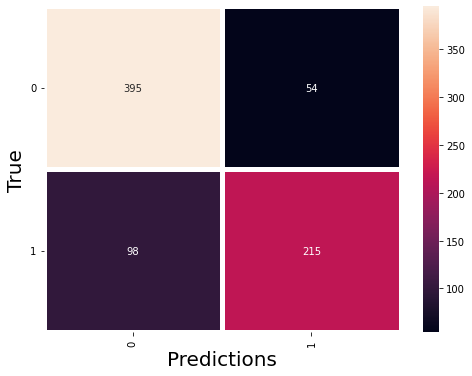

In [247]:
calculate_results(val_labels, predictions)

### Using a Universal Sentence Encoder

In [19]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [31]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        name='USE')

x = sentence_encoder_layer(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [32]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [33]:
history = model.fit(train_sentences,
                    train_labels,
                    epochs=5,
                    batch_size=32,
                    validation_data=(val_sentences, val_labels),
                    validation_batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                                patience=3,
                                                                restore_best_weights=True)])

Epoch 1/5
215/215 [==============================] - 14s 51ms/step - loss: 0.4903 - accuracy: 0.7881 - val_loss: 0.3800 - val_accuracy: 0.8360
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4144 - accuracy: 0.8149 - val_loss: 0.3739 - val_accuracy: 0.8412
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4006 - accuracy: 0.8224 - val_loss: 0.3686 - val_accuracy: 0.8373
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3903 - accuracy: 0.8282 - val_loss: 0.3660 - val_accuracy: 0.8425
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3789 - accuracy: 0.8351 - val_loss: 0.3633 - val_accuracy: 0.8478


## Competition Submission

In [35]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [38]:
preds = tf.round(tf.squeeze(model.predict(test_df['text'], batch_size=32)))

102/102 [==============================] - 1s 8ms/step


In [43]:
submission = pd.read_csv('sample_submission.csv', index_col='id')
submission.head()

,target
id,
0,0
2,0
3,0
9,0
11,0


In [48]:
submission['target'] = tf.cast(preds, tf.int32)
submission

,target
id,
0,1
2,1
3,1
9,1
11,1
...,...
10861,1
10865,1
10868,1


In [49]:
submission.to_csv('submission001.csv')